In [2]:
import tensorflow as tf
from utils import util_functions as utils

2024-12-27 01:00:58.466825: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-27 01:00:58.466851: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-27 01:00:58.466856: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-27 01:00:58.466931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 01:00:58.467201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
class LSTM(utils.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    get_weights = lambda num_inputs, num_hiddens: (
      tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=sigma)),
      tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=sigma)),
      tf.Variable(tf.zeros(shape=(num_hiddens)))
    )

    self.W_xi, self.W_hi, self.b_i = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Input gate
    self.W_xf, self.W_hf, self.b_f = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Forget gate
    self.W_xo, self.W_ho, self.b_o = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Output gate
    self.W_xc, self.W_hc, self.b_c = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Input node

  def forward(self, X, H_C=None):
    """
    inputs:  (num_batches, num_steps, num_inputs)
    outputs: (num_batches, num_steps, num_inputs), ((num_batches, num_hiddens), (num_batches, num_hiddens))
    """
    num_batches, num_steps, num_inputs = X.shape
    outputs = []
    if H_C is None:
      H_C = (tf.zeros(shape=(num_batches, self.num_hiddens)), tf.zeros(shape=(num_batches, self.num_hiddens)))
    H, C = H_C

    X_t = tf.transpose(X, perm=[1, 0, 2])
    ## (num_steps, num_batches, num_inputs)
    for x in X_t:
      I = tf.sigmoid(tf.matmul(x, self.W_xi) + tf.matmul(H, self.W_hi) + self.b_i)
      F = tf.sigmoid(tf.matmul(x, self.W_xf) + tf.matmul(H, self.W_hf) + self.b_f)
      O = tf.sigmoid(tf.matmul(x, self.W_xo) + tf.matmul(H, self.W_ho) + self.b_o)
      C_tilde = tf.tanh(tf.matmul(x, self.W_xc) + tf.matmul(H, self.W_hc) + self.b_c)

      C = tf.multiply(F, C) + tf.multiply(I, C_tilde)
      H = tf.multiply(O, tf.tanh(C))
      outputs.append(H)

    return tf.stack(outputs, axis=1), (H, C)

In [3]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = LSTM(num_inputs=num_inputs, num_hiddens=num_hiddens, sigma=0.1)
X = tf.ones(shape=(batch_size, num_steps, num_inputs))
output, state = rnn(X)

In [4]:
output.shape

TensorShape([2, 100, 32])

KeyboardInterrupt: 

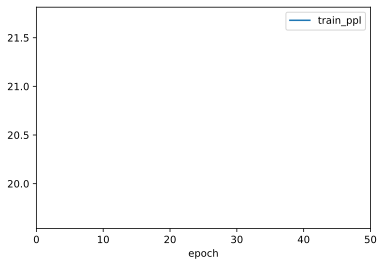

In [5]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  rnn = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
  model = utils.RNNLM(rnn=rnn, vocab_size=len(data.vocab), lr=4)
  Trainer = utils.Trainer(max_epochs=50, gradient_clip_val=1)
  Trainer.fit(model, data)

model.predict('i am ', 20, data.vocab)

In [6]:
class LSTM(utils.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.lstm = tf.keras.layers.LSTM(units=num_hiddens, return_sequences=True, return_state=True, time_major=True)

  def forward(self, X, H_C=None):
    """
    inputs:  (num_batches, num_steps, num_inputs)
    outputs: (num_batches, num_steps, num_inputs), ((num_batches, num_hiddens), (num_batches, num_hiddens))
    """
    outputs, *H_C = self.lstm(X, H_C)

    return outputs, H_C

In [ ]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  rnn = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
  model = utils.RNNLM(rnn=rnn, vocab_size=len(data.vocab), lr=4)
  Trainer = utils.Trainer(max_epochs=10, gradient_clip_val=1)
  Trainer.fit(model, data)

model.predict('i am ', 20, data.vocab)

### GRU

In [8]:
class GRU(utils.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    get_weights = lambda num_inputs, num_hiddens: (
      tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens), mean=0, stddev=sigma)),
      tf.Variable(tf.random.normal(shape=(num_hiddens, num_hiddens), mean=0, stddev=sigma)),
      tf.Variable(tf.zeros(shape=(num_hiddens)))
    )

    self.W_xr, self.W_hr, self.b_r = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Reset Gate
    self.W_xz, self.W_hz, self.b_z = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Update Gate
    self.W_xh, self.W_hh, self.b_h = get_weights(num_inputs=num_inputs, num_hiddens=num_hiddens)  # Candidate Reset Gate

  def forward(self, X, H_C=None):
    """
    inputs:  (num_batches, num_steps, num_inputs)
    outputs: (num_batches, num_steps, num_inputs), ((num_batches, num_hiddens), (num_batches, num_hiddens))
    """
    num_batches, num_steps, num_inputs = X.shape
    outputs = []
    if H_C is None:
      H_C = (tf.zeros(shape=(num_batches, self.num_hiddens)), tf.zeros(shape=(num_batches, self.num_hiddens)))
    H, C = H_C

    X_t = tf.transpose(X, perm=[1, 0, 2])
    ## (num_steps, num_batches, num_inputs)
    for x in X_t:
      R = tf.sigmoid(tf.matmul(x, self.W_xr) + tf.matmul(H, self.W_hr) + self.b_r)
      Z = tf.sigmoid(tf.matmul(x, self.W_xz) + tf.matmul(H, self.W_hz) + self.b_z)
      H_tilde = tf.tanh(tf.matmul(x, self.W_xh) + tf.matmul(tf.multiply(R, H), self.W_hh) + self.b_h)

      H = tf.multiply(Z, H) + tf.multiply(1-Z, H_tilde)
      outputs.append(H)

    return tf.stack(outputs, axis=1), (H, C)

In [ ]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
  model = utils.RNNLM(rnn=gru, vocab_size=len(data.vocab), lr=4)
  Trainer = utils.Trainer(max_epochs=10, gradient_clip_val=1)
  Trainer.fit(model, data)

model.predict('i am ', 20, data.vocab)

### Deep RNNs

In [6]:
class DeepRNN(utils.Module):
  def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.rnns = [
      utils.RNN(num_inputs=num_inputs if i == 0 else num_hiddens, num_hiddens=num_hiddens, sigma=sigma) for i in range(num_layers)]

  def forward(self, X, Hs=None):
    """
    inputs:  (num_batches, num_steps, num_inputs)
    outputs: (num_batches, num_steps, num_hiddens), (num_batches, num_hiddens)
    """
    outputs = X
    if Hs is None:
      Hs = [None] * self.num_layers
    for i in range(self.num_layers):
      outputs, Hs[i] = self.rnns[i](X=outputs, state=Hs[i])

    return outputs, Hs

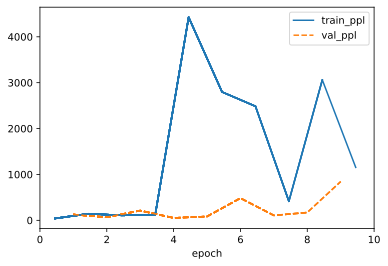

In [ ]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  rnn = DeepRNN(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
  model = utils.RNNLM(rnn=rnn, vocab_size=len(data.vocab), lr=4)
  Trainer = utils.Trainer(max_epochs=10, gradient_clip_val=1)
  Trainer.fit(model, data)

In [ ]:
model.predict('i am ', 20, data.vocab)

In [11]:
## Concise Implementation

In [3]:
class DeepRNN(utils.Module):
  def __init__(self, num_hiddens, num_layers, dropout=0.01, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    gru_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.GRUCell(units=num_hiddens, dropout=dropout) for _ in range(num_layers)])
    self.rnn = tf.keras.layers.RNN(gru_cells, return_sequences=True, return_state=True, time_major=True)

  def forward(self, X, state=None):
    outputs, *state = self.rnn(X, state)
    return outputs, state

In [ ]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  rnn = DeepRNN(num_hiddens=32, num_layers=2)
  model = utils.RNNLM(rnn=rnn, vocab_size=len(data.vocab), lr=2)
  Trainer = utils.Trainer(max_epochs=10, gradient_clip_val=1)
  Trainer.fit(model, data)

In [4]:
rnn = DeepRNN(num_hiddens=32, num_layers=2)

In [6]:
outputs, states = rnn(tf.ones((1024, 32, 16), dtype=tf.float32))

In [9]:
len(states)

2

In [7]:
outputs.shape

TensorShape([1024, 32, 32])

In [ ]:
model.predict('i am ', 20, data.vocab)

In [23]:
class BiRNNScratch(utils.Module):
  def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.f_rnn = utils.RNN(num_inputs=num_inputs, num_hiddens=num_hiddens, sigma=0.1)
    self.b_rnn = utils.RNN(num_inputs=num_inputs, num_hiddens=num_hiddens, sigma=0.1)
    self.num_hiddens *= 2

  def forward(self, X, Hs=None):
    if Hs is None:
      f_H, b_H = Hs if Hs is not None else (None, None)
    f_outputs, f_H = self.f_rnn(X=X, state=f_H)
    b_outputs, b_H = self.b_rnn(X=tf.reverse(X, axis=[1]), state=b_H)
    b_outputs = tf.reverse(b_outputs, axis=[1])

    return tf.concat([f_outputs, b_outputs], axis=-1), (f_H, b_H)

In [ ]:
with tf.device('CPU: 0'):
  data = utils.TimeMachine(batch_size=1024, num_steps=32)
  rnn = BiRNNScratch(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
  model = utils.RNNLM(rnn=rnn, vocab_size=len(data.vocab), lr=2)
  Trainer = utils.Trainer(max_epochs=10, gradient_clip_val=1)
  Trainer.fit(model, data)

In [ ]:
model.predict('i am ', 20, data.vocab)

In [1]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
class MTFraEng(d2l.DataModule):
  def _download(self):
    d2l.extract(d2l.download(d2l.DATA_URL+'fra-eng.zip', self.root, '94646ad1522d915e7b0f9296181140edcf86a4f5'))
    with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
      return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:175])

In [ ]:
import tensorflow as tf
from utils import util_functions as utils

rnn = utils.DeepRNN(num_hiddens=32, num_layers=2)

In [2]:
X = tf.zeros(shape=(9, 32, 64))
outputs, state = rnn(X=X, state=None)

In [ ]:
outputs.shape

In [ ]:
state.shape